In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
file_path = "data/voice.csv"
data = pd.read_csv(file_path)
data['label'] = data['label'].map({'male': 1, 'female': 0})

X = data.drop(columns=['label']).values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0)

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_safe(z):
    return np.clip(sigmoid(z), 1e-7, 1 - 1e-7)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return np.where(z > 0, 1, 0)

def batch_norm_forward(Z, gamma, beta, eps=1e-5):
    mu = np.mean(Z, axis=1, keepdims=True)
    var = np.var(Z, axis=1, keepdims=True)
    Z_norm = (Z - mu) / np.sqrt(var + eps)
    out = gamma * Z_norm + beta
    cache = (Z, Z_norm, mu, var, gamma, beta, eps)
    return out, cache

def batch_norm_backward(dout, cache):
    Z, Z_norm, mu, var, gamma, beta, eps = cache
    m = Z.shape[1]

    dZ_norm = dout * gamma
    dvar = np.sum(dZ_norm * (Z - mu) * -0.5 * (var + eps)**(-1.5), axis=1, keepdims=True)
    dmu = np.sum(dZ_norm * -1 / np.sqrt(var + eps), axis=1, keepdims=True) + dvar * np.sum(-2 * (Z - mu), axis=1, keepdims=True) / m

    dZ = dZ_norm / np.sqrt(var + eps) + dvar * 2 * (Z - mu) / m + dmu / m
    dgamma = np.sum(dout * Z_norm, axis=1, keepdims=True)
    dbeta = np.sum(dout, axis=1, keepdims=True)

    return dZ, dgamma, dbeta

def initialisation(n0, n1, n2):
    W1 = np.random.randn(n1, n0) * 0.01
    b1 = np.zeros((n1, 1))
    gamma1 = np.ones((n1, 1))
    beta1 = np.zeros((n1, 1))

    W2 = np.random.randn(n2, n1) * 0.01
    b2 = np.zeros((n2, 1))

    parameter = {'W1': W1, 'b1': b1, 'gamma1': gamma1, 'beta1': beta1, 'W2': W2, 'b2': b2}
    return parameter

def forward_propagation(X, parameter):
    W1 = parameter['W1']
    b1 = parameter['b1']
    gamma1 = parameter['gamma1']
    beta1 = parameter['beta1']

    W2 = parameter['W2']
    b2 = parameter['b2']

    Z1 = W1.dot(X) + b1
    A1, cache_bn1 = batch_norm_forward(Z1, gamma1, beta1)
    A1 = relu(A1)

    Z2 = W2.dot(A1) + b2
    A2 = sigmoid_safe(Z2)

    activations = {'A1': A1, 'A2': A2, 'cache_bn1': cache_bn1}
    return activations

def back_propagation(X, y, parameter, activations):
    A1 = activations['A1']
    A2 = activations['A2']
    cache_bn1 = activations['cache_bn1']

    W2 = parameter['W2']
    m = y.shape[1]

    dZ2 = A2 - y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.dot(W2.T, dZ2)
    dA1_relu = dA1 * relu_derivative(A1)
    dZ1, dgamma1, dbeta1 = batch_norm_backward(dA1_relu, cache_bn1)

    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {'dW1': dW1, 'db1': db1, 'dgamma1': dgamma1, 'dbeta1': dbeta1, 'dW2': dW2, 'db2': db2}
    return gradients

def update(gradients, parameter, learning_rate):
    parameter['W1'] -= learning_rate * gradients['dW1']
    parameter['b1'] -= learning_rate * gradients['db1']
    parameter['gamma1'] -= learning_rate * gradients['dgamma1']
    parameter['beta1'] -= learning_rate * gradients['dbeta1']

    parameter['W2'] -= learning_rate * gradients['dW2']
    parameter['b2'] -= learning_rate * gradients['db2']

    return parameter

def predict(X, parameter):
    activations = forward_propagation(X, parameter)
    A2 = activations['A2']
    return (A2 >= 0.5).astype(int)

def neural_network(X, y, n1=16, learning_rate=0.1, n_iter=1000):
    n0 = X.shape[0]
    n2 = y.shape[0]
    np.random.seed(0)

    parameters = initialisation(n0, n1, n2)
    train_loss = []
    train_acc = []

    for i in tqdm(range(n_iter)):
        activations = forward_propagation(X, parameters)
        A2 = activations['A2']

        train_loss.append(log_loss(y.flatten(), A2.flatten()))
        y_pred = predict(X, parameters)
        train_acc.append(accuracy_score(y.flatten(), y_pred.flatten()))

        gradients = back_propagation(X, y, parameters, activations)
        parameters = update(gradients, parameters, learning_rate)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.legend()
    plt.show()

    return parameters

100%|██████████| 100/100 [00:01<00:00, 84.25it/s]


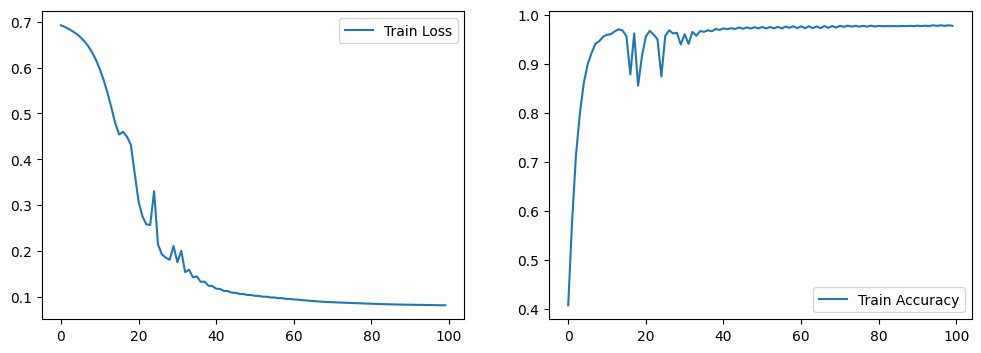

In [4]:
X = X_train.T
y = y_train.reshape((1, y_train.shape[0]))

parametres_final = neural_network(X, y, n1=16, learning_rate=0.01, n_iter=100)


In [5]:
X_test = X_test.T
y_test = y_test.reshape((1, y_test.shape[0]))

c:\Users\Antoine\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.4685
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


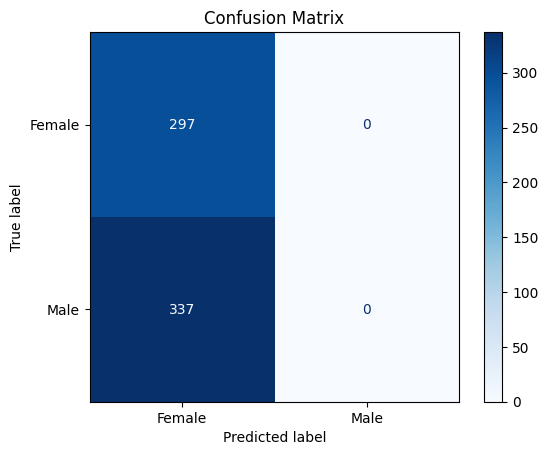

In [6]:
y_test_pred = predict(X_test, parametres_final)

accuracy = accuracy_score(y_test.flatten(), y_test_pred.flatten())
precision = precision_score(y_test.flatten(), y_test_pred.flatten())
recall = recall_score(y_test.flatten(), y_test_pred.flatten())
f1 = f1_score(y_test.flatten(), y_test_pred.flatten())

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test.flatten(), y_test_pred.flatten())
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Female', 'Male'])
cm_display.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
